In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pickle

plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)


In [2]:
RAW_DATA_DIR = Path(r"C:\Users\MSI GF66\OneDrive - National Polyechnic University of Armenia\Desktop\Emotion_recognition\data\raw\lfw\lfw-deepfunneled\lfw-deepfunneled")
PROCESSED_DIR = Path(r"C:\Users\MSI GF66\OneDrive - National Polyechnic University of Armenia\Desktop\Emotion_recognition\data\processed\faces")
RESULTS_DIR = Path(r"C:\Users\MSI GF66\OneDrive - National Polyechnic University of Armenia\Desktop\Emotion_recognition\results\face_preprocessing")

PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

TARGET_SIZE = (160, 160)
MIN_SAMPLES_PER_PERSON = 10
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15

print(f"Raw data directory: {RAW_DATA_DIR}")
print(f"Processed data: {PROCESSED_DIR}")

Raw data directory: C:\Users\MSI GF66\OneDrive - National Polyechnic University of Armenia\Desktop\Emotion_recognition\data\raw\lfw\lfw-deepfunneled\lfw-deepfunneled
Processed data: C:\Users\MSI GF66\OneDrive - National Polyechnic University of Armenia\Desktop\Emotion_recognition\data\processed\faces


## Loading and filtering dataset

In [3]:
def load_and_filter_dataset(data_dir, min_samples=10):
    dataset = []
    for person in os.listdir(data_dir):
        person_path = os.path.join(data_dir, person)
        if not os.path.isdir(person_path):
            continue
        images = [os.path.join(person_path, f)
                  for f in os.listdir(person_path)
                  if f.endswith(('.jpg', '.png'))]
        if len(images) >= min_samples:
            for img_path in images:
                dataset.append({'path': img_path, 'person': person})
    return pd.DataFrame(dataset)

df = load_and_filter_dataset(RAW_DATA_DIR, MIN_SAMPLES_PER_PERSON)
unique_people = sorted(df['person'].unique())
person_to_id = {p: i for i, p in enumerate(unique_people)}
df['person_id'] = df['person'].map(person_to_id)

print(f"Filtered dataset: {len(df)} images, {len(unique_people)} identities")
df.head()

Filtered dataset: 4324 images, 158 identities


,path,person,person_id
0,C:\Users\MSI GF66\OneDrive - National Polyechn...,Abdullah_Gul,0
1,C:\Users\MSI GF66\OneDrive - National Polyechn...,Abdullah_Gul,0
2,C:\Users\MSI GF66\OneDrive - National Polyechn...,Abdullah_Gul,0
3,C:\Users\MSI GF66\OneDrive - National Polyechn...,Abdullah_Gul,0
4,C:\Users\MSI GF66\OneDrive - National Polyechn...,Abdullah_Gul,0


## Face detection and cropping

In [4]:
def detect_and_crop_face(img_path, target_size=(160, 160), margin=20):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +
                                         'haarcascade_frontalface_default.xml')
    img = cv2.imread(img_path)
    if img is None:
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 5)

    if len(faces) == 0:
        h, w = img.shape[:2]
        s = min(h, w)
        x, y = (w-s)//2, (h-s)//2
        crop = img[y:y+s, x:x+s]
    else:
        x, y, w, h = max(faces, key=lambda f: f[2]*f[3])
        x, y = max(0, x-margin), max(0, y-margin)
        w, h = w+2*margin, h+2*margin
        crop = img[y:y+h, x:x+w]

    resized = cv2.resize(crop, target_size)
    return cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)


## Normalization

In [5]:
def normalize_image(img, method='facenet'):
    img = img.astype(np.float32)
    if method == 'standard':
        return img / 255.0
    elif method == 'facenet':
        return (img - 127.5) / 127.5
    else:
        raise ValueError("Invalid normalization method")


## Augmentation

In [6]:
def augment_image(img):
    img_aug = img.copy()
    if np.random.rand() > 0.5:
        img_aug = cv2.flip(img_aug, 1)
    if np.random.rand() > 0.5:
        factor = np.random.uniform(0.8, 1.2)
        img_aug = np.clip(img_aug * factor, 0, 255).astype(np.uint8)
    if np.random.rand() > 0.5:
        angle = np.random.uniform(-10, 10)
        h, w = img_aug.shape[:2]
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
        img_aug = cv2.warpAffine(img_aug, M, (w, h), borderMode=cv2.BORDER_REFLECT)
    return img_aug


## Splitting

In [8]:
def stratified_split_fast(df, val_split=0.15, test_split=0.15):
    train, val, test = [], [], []
    val_ratio = val_split / (1 - test_split)

    for person, person_df in df.groupby('person'):
        if len(person_df) < 3:
            train.append(person_df)
            continue

        train_val, test_df = train_test_split(person_df, test_size=test_split, random_state=42)
        train_df, val_df = train_test_split(train_val, test_size=val_ratio, random_state=42)

        train.append(train_df)
        val.append(val_df)
        test.append(test_df)

    return (
        pd.concat(train).reset_index(drop=True),
        pd.concat(val).reset_index(drop=True),
        pd.concat(test).reset_index(drop=True)
    )

train_df, val_df, test_df = stratified_split_fast(df)
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 2906, Val: 700, Test: 718


## Process and save dataset

In [9]:
def process_dataset(df, normalize_method='facenet', augment=False):
    images, labels = [], []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        img = detect_and_crop_face(row['path'])
        if img is None:
            continue
        if augment:
            img = augment_image(img)
        img = normalize_image(img, normalize_method)
        images.append(img)
        labels.append(row['person_id'])
    return np.array(images, np.float32), np.array(labels, np.int32)

X_train, y_train = process_dataset(train_df, augment=True)
X_val, y_val = process_dataset(val_df)
X_test, y_test = process_dataset(test_df)


100%|██████████| 718/718 [00:25<00:00, 28.22it/s]


In [10]:
np.save(PROCESSED_DIR / 'X_train.npy', X_train)
np.save(PROCESSED_DIR / 'y_train.npy', y_train)
np.save(PROCESSED_DIR / 'X_val.npy', X_val)
np.save(PROCESSED_DIR / 'y_val.npy', y_val)
np.save(PROCESSED_DIR / 'X_test.npy', X_test)
np.save(PROCESSED_DIR / 'y_test.npy', y_test)

label_mapping = {
    'person_to_id': person_to_id,
    'id_to_person': {v: k for k, v in person_to_id.items()},
    'num_classes': len(person_to_id),
    'target_size': TARGET_SIZE
}
with open(PROCESSED_DIR / 'label_mapping.pkl', 'wb') as f:
    pickle.dump(label_mapping, f)


## Visualization

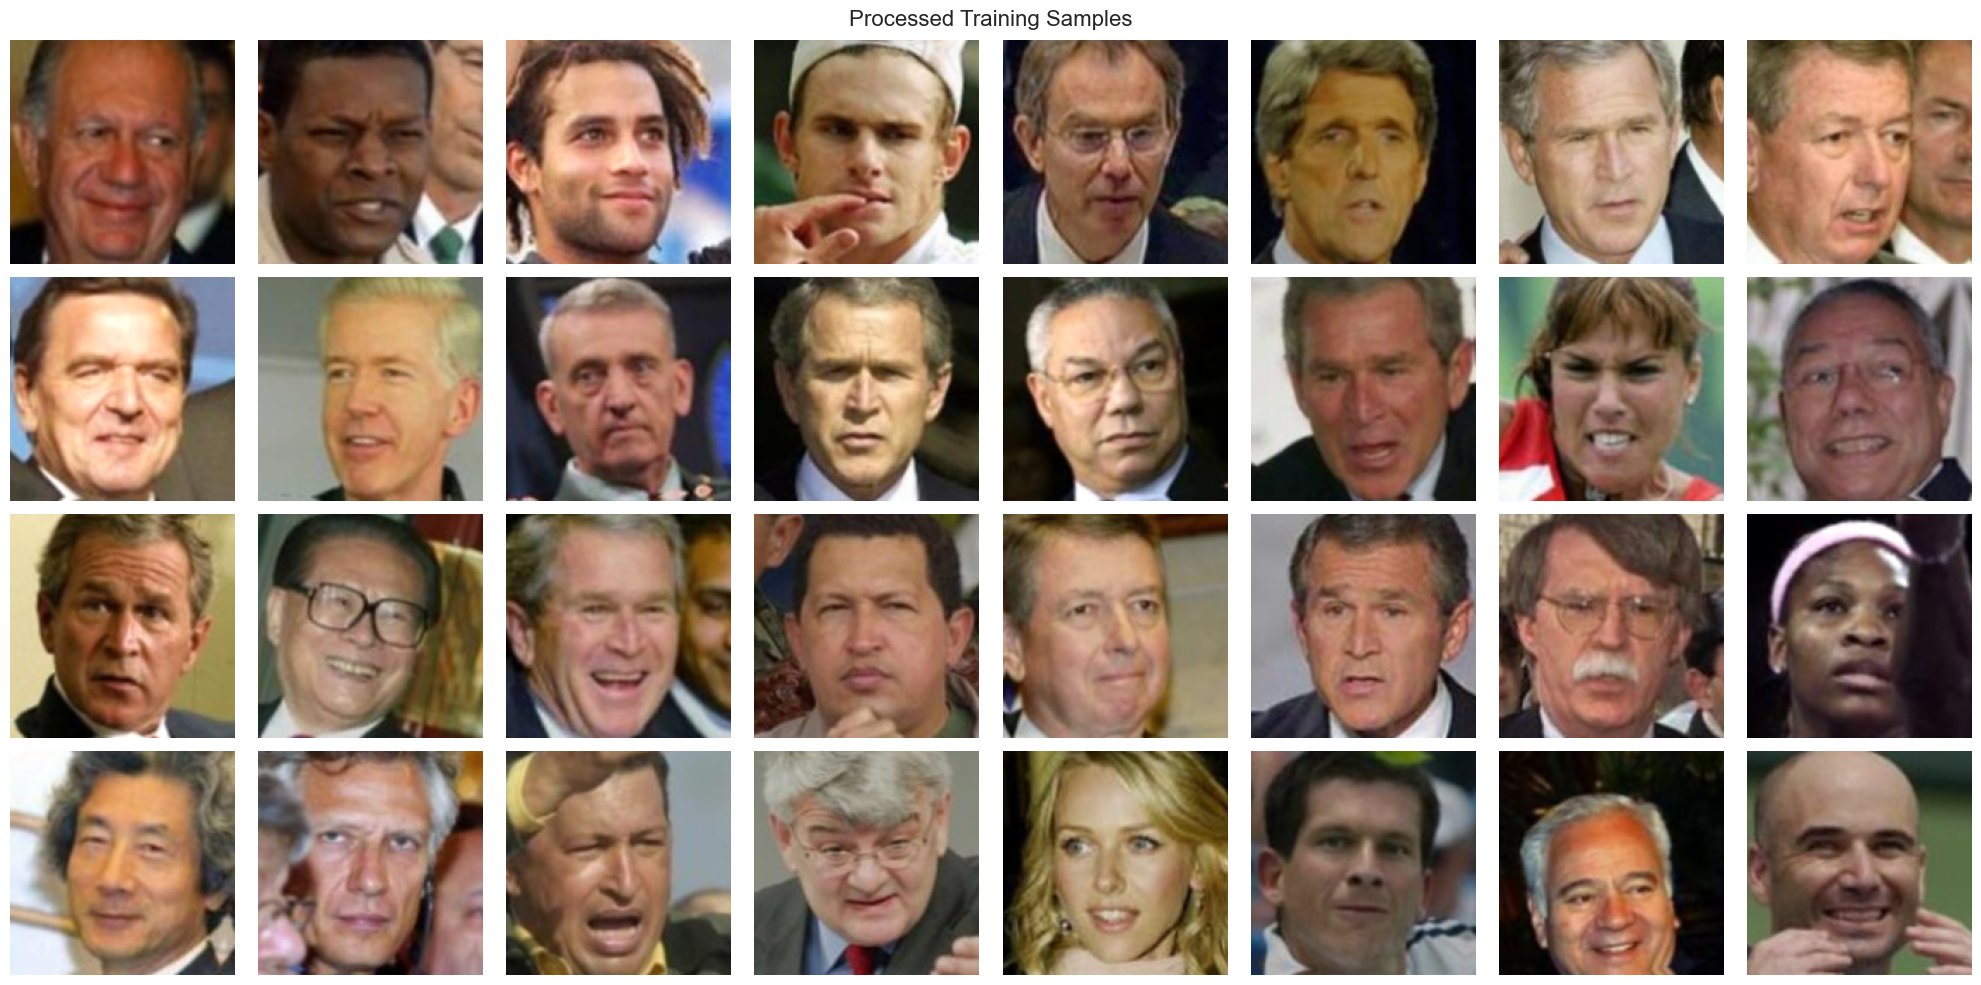

In [11]:
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
fig.suptitle('Processed Training Samples', fontsize=16)

indices = np.random.choice(len(X_train), 32, replace=False)
for ax, idx in zip(axes.flat, indices):
    ax.imshow((X_train[idx] + 1) / 2)
    ax.axis('off')
plt.tight_layout()
plt.show()
